In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
import unidecode

In [11]:
# glove_embeddings = dict()
# f = open('glove/glove.twitter.27B.25d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     glove_embeddings[word] = coefs
# f.close()

In [12]:
# glove_embeddings["not"]

array([ 0.35377 ,  0.32604 , -0.22682 , -0.32412 , -0.18555 ,  0.1486  ,
        1.3914  , -0.65154 , -0.38197 ,  0.17129 , -0.43405 ,  0.39154 ,
       -5.7918  , -0.20201 , -0.23216 , -0.10638 ,  0.070835, -0.2146  ,
       -0.094385, -1.0851  ,  0.61683 ,  0.82184 , -0.35102 ,  0.19177 ,
       -0.43818 ], dtype=float32)

In [8]:
import spacy

# run this in the terminal
# "python -m spacy download en_core_web_lg"

nlp = spacy.load("en_core_web_lg")

In [9]:

# code examples:
# also contain contractions
# https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f#file-text_preprocessing-py-L22
def lower_case(text):
    return text.lower()

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

In [10]:
def clean_text(text):
    clean_text = ''
    doc = nlp(text)
    for token in doc:
        include_flag = True                   
        if token.is_stop == True:
            include_flag = False
        if (token.pos_ =='PUNCT') | (token.is_punct):
            include_flag = False
        if token.pos_ =='SYM':
            include_flag = False
        if token.like_url:
            include_flag = False
        if token.like_email:
            include_flag = False            
        if include_flag:
            clean_text = clean_text + token.lemma_ + " "
    return clean_text.strip()

In [11]:
text = "no way I ca n't eat that shit"
clean_text(text)

'way eat shit'

# read in data, and cleaning

In [13]:
df = pd.read_csv('train.csv', dtype =object,  usecols= ['id', 'text', 'target'])

In [14]:
# note: even if we don't handel the http:xx content and the @xxx content, it will 
df['text_1'] = df['text'].map(lower_case)
df['text_2'] = df['text_1'].map(remove_whitespace)
df['text_3'] = df['text_2'].map(remove_accented_chars)
df['text_4'] = df['text_3'].map(clean_text)

In [15]:
df['text_clean'] = df['text_4']

In [16]:
df.to_csv('df_train_temp.csv', index=False)

# Try bert model 

In [ ]:
# use small bert 
# https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2

# try RNN

In [ ]:
df['target'] = df['target'].astype(float)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)
target = df.pop('target')

In [ ]:
vocab_size = 8000
embedding_dim = 25

max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train['text_clean'])
word_index = tokenizer.word_index

# use index method 

training_sequences = tokenizer.texts_to_sequences(df_train['text_clean'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(df_test['text_clean'])
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# this still may be converted to a vectorization layer

In [ ]:
# for word, index in tokenizer.word_index.items():
#     if word != '<OOV>':
#         print(word + ' ' + 'count: ' + str(tokenizer.word_counts[word]))
# # len(tokenizer.word_index)
# # # tokenizer.word_counts['t']

# tokenizer.word_counts["http"]

In [ ]:
# embedding_matrix is a numpy array, where the row index represents the token index
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
# look for the coverage
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

In [198]:
len(cumulative_y)

12902

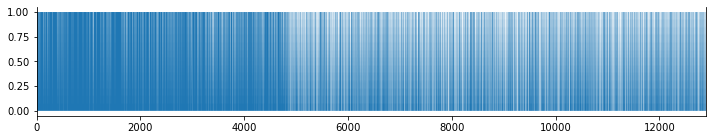

In [199]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)

[0.7088823438226631]


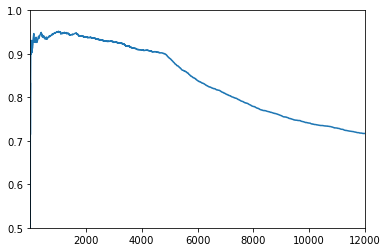

In [200]:
import matplotlib.pyplot as plt
plt.plot(cumulative_x, cumulative_y)
plt.axis([1, 12000 , 0.5, 1])
print(cumulative_y[-1:])

# for now, just use 6000

In [201]:
training_padded

array([[   0,    0,    0, ...,   68,  312, 1711],
       [   0,    0,    0, ..., 1355, 4843, 4844],
       [   0,    0,    0, ...,  313,   46,  340],
       ...,
       [   0,    0,    0, ...,  797,  751,  635],
       [   0,    0,    0, ..., 2329,    1,    1],
       [   0,    0,    0, ...,    3, 3241,  362]], dtype=int32)

In [ ]:
print('embedding_dim:' +  str(embedding_dim))
print('embedding_dim:' +  str(max_length))

In [203]:
# model=tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.LSTM(embedding_dim),
# #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    
#     tf.keras.layers.Dense(24, activation ='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# import tensorflow_addons as tfa

In [204]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True, dropout=0.4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.4)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# optimizer = tf.keras.optimizers.Adam(lr=0.0007)
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
# what is the beta_1 and beta_2? 

# optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), 
                                                                   tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model.summary()

# how to add in precision and recall? 


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 25)          200000    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 50)          10200     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 306       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 7         
Total params: 225,713
Trainable params: 25,713
Non-trainable params: 200,000
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model.fit(training_padded, df_train['target'], epochs=num_epochs, validation_data=(testing_padded, df_test['target']),
                   callbacks=[callback])

Epoch 1/50
191/191 [==============================] - 41s 201ms/step - loss: 0.6266 - accuracy: 0.6431 - precision_5: 0.6253 - recall_5: 0.3648 - auc_1: 0.6636 - val_loss: 0.4906 - val_accuracy: 0.7643 - val_precision_5: 0.8036 - val_recall_5: 0.6057 - val_auc_1: 0.8413
Epoch 2/50
191/191 [==============================] - 37s 193ms/step - loss: 0.5177 - accuracy: 0.7526 - precision_5: 0.7457 - recall_5: 0.6390 - auc_1: 0.8145 - val_loss: 0.4752 - val_accuracy: 0.7708 - val_precision_5: 0.7893 - val_recall_5: 0.6450 - val_auc_1: 0.8491
Epoch 3/50
127/191 [==================>...........] - ETA: 11s - loss: 0.4922 - accuracy: 0.7719 - precision_5: 0.7671 - recall_5: 0.6581 - auc_1: 0.8284

In [ ]:
# continue from here 

In [ ]:
test_target_pred = (model.predict(testing_padded) > 0.5).astype(int)
# test_target_pred_class = model.predict_classes(testing_padded)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print('accuracy: ' + str(accuracy_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('precision: ' +  str(precision_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('recall: ' + str(recall_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('f1: ' +  str(f1_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('auc: ' +  str(roc_auc_score(y_score=test_target_pred, y_true=df_test['target'])))


In [ ]:
model.metrics_names

In [ ]:
loss, accuracy, precision, recall = model.evaluate(x=testing_padded, y = df_test['target'])

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print('precision: ', precision)
print('recall: ', recall)


In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# for ele, text in ds_test_raw.take(-1):
#     print(ele)

# t = ds_test_raw.map(lambda x, y: x.numpy())